In [ ]:
!pip install gymnasium matplotlib numpy

In [ ]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import pickle
import copy

# Env parameters
env_height, env_width = 4,4
no_actions = 4

# Learning parameters
gamma = 0.9
alpha = 0.3
no_episodes = 3000
no_steps = 24

In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ["human", "rgb_array"] }
    def __init__(self):
        # Maximum steps before we end the episode
        self.max_timesteps = no_steps
        # Init timestep to 0
        self.timestep = 0
        self.random_action_count = 0

        self.environment_height, self.environment_width = env_height, env_width
        # How much of the environment is visible to the agent
        self.observation_space = spaces.Discrete(1)
        # No of directions the agent can move in
        self.action_space = spaces.Discrete(no_actions)

        # Agent starts at the first box
        self.agent_pos = np.asarray([0, 0])
        # Terminal position is bottom right square
        self.goal_pos = np.asarray([3, 3])
        self.reward_pos = np.asarray([[1,1],[1,3]])
        self.regret_pos = np.asarray([[3,1],[1,2]])


    def reset(self, **kwargs):
        # Reset timesteps, rewards, and agent position
        self.timestep = 0
        self.reward_pos = np.asarray([[1,1],[1,3]])
        self.agent_pos = np.asarray([0, 0])
        # TODO: Am I sending the right observation back?
        observation = 0
        # What's the point of info?
        info = {}
        return observation, info

    def step(self, action, prob):
        # print("ACTION TAKEN", action)
        rand = np.random.random()
        # if prob is not 1, then there's a 1-prob chance of picking a random action
        if rand > prob:
          # Generate a number between 0 and action_space(8)
          old_action = action
          action = np.random.randint(0, self.action_space.n)
          # self.random_action_count += 1
          # print("Random action for num:",rand,prob, self.random_action_count)

        # 4 possible actions in all directions
        if action == 0:
          # Move right (up)
          self.agent_pos[1] += 1
        if action == 1:
          # Move down (right)
          self.agent_pos[0] += 1
        if action == 2:
          # Move left (down)
          self.agent_pos[1] -= 1
        if action == 3:
          # Move up (left)
          self.agent_pos[0] -= 1


        # Comment this to demonstrate the truncation condition.
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        # print("AGENT POS", self.agent_pos)
        # Agent's current position
        observation = self.agent_pos[0] * 4 + self.agent_pos[1]
        info = {}
        reward = 0

        terminated = False
        # If the agent reached the goal, reward is 10 and terminated is true.
        if np.array_equal(self.agent_pos, self.goal_pos):
          reward = 10
          terminated = True

        # Else if it reaches a trap
        elif  any(np.array_equal(self.regret_pos[i], self.agent_pos) for i in range(len(self.regret_pos))):
          reward = -5
        # Else if it reaches the reward
        else:
          for i in range(len(self.reward_pos)):
            if np.array_equal(self.agent_pos, self.reward_pos[i]):
              self.reward_pos = np.delete(self.reward_pos, i, axis=0)
              reward = 3
              break

        # Increment timestep
        self.timestep += 1

        terminated = True if self.timestep >= self.max_timesteps else terminated
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

        return observation, reward, terminated, truncated, info

    def render(self):
        # first of all, the base transformation of the data points is needed
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xlim(0,self.environment_width)
        ax.set_ylim(0,self.environment_height)
        print("CURRENT AGENT POSITION", self.agent_pos)
        def plot_image(plot_pos):
          plot_agent, plot_reward, plot_goal, plot_regret = False, False, False, False

          # Figuring out what to plot
          if np.array_equal(self.agent_pos, plot_pos):
            plot_agent = True
          if any(np.array_equal(self.reward_pos[i], plot_pos) for i in range(len(self.reward_pos))):
              plot_reward = True
          if any(np.array_equal(self.regret_pos[i], plot_pos) for i in range(len(self.regret_pos))):
            plot_regret = True
          if np.array_equal(self.goal_pos, plot_pos):
            plot_goal = True

          # # Actually plotting
          if plot_agent and plot_regret:
            mouseintrap = AnnotationBbox(OffsetImage(plt.imread('./mouseandtrap.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mouseintrap)
          elif plot_agent and plot_reward:
            mousewithcheese = AnnotationBbox(OffsetImage(plt.imread('./mouseandcheese.jpg'), zoom=1),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(mousewithcheese)
          elif plot_agent and plot_goal:
            agentatgoal = AnnotationBbox(OffsetImage(plt.imread('./mouseandgold.jpg'), zoom=.8),
            np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agentatgoal)
          elif plot_agent:
            agent = AnnotationBbox(OffsetImage(plt.imread('./mouse.jpg'), zoom=0.3),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(agent)
          elif plot_regret:
            regret = AnnotationBbox(OffsetImage(plt.imread('./mousetrap.jpg'), zoom=1),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(regret)
          elif plot_reward:
            reward = AnnotationBbox(OffsetImage(plt.imread('./cheese.jpg'), zoom=0.5),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(reward)
          elif plot_goal:
            goal = AnnotationBbox(OffsetImage(plt.imread('./gold.jpg'), zoom=1.2),
                                    np.add(plot_pos, [0.5, 0.5]), frameon=False)
            ax.add_artist(goal)

        coordinates_state_mapping = {}
        for j in range(self.environment_height * self.environment_width): # j iterates 16 times (0 - 15)
          coordinates_state_mapping[j] = np.asarray([j % self.environment_width, int(np.floor(j/ self.environment_width))])

        for position in coordinates_state_mapping:
          plot_image(coordinates_state_mapping[position])

        plt.xticks([0,1,2,3])
        plt.yticks([0,1,2,3])
        plt.grid()
        plt.show()


        # plt.imshow(self.state)

In [ ]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs, Qt, ep):
    # Choose action A from from state S using policy derived from Q
    # Generate random number, if lesser than epsilon - Random action
    rand = np.random.random()
    if rand < ep:
      action = np.random.choice(self.action_space.n)
      # print("Taking random action, rand, epsilon, action",rand, ep, action)
      return action
      #Else Best action - look at Q table and see which action has the best Q value for current state (or observation)
    else:
      # Returns index of greedy action
      action = np.argmax(Qt[obs])
      # print("Taking greedy action", action)
      return action




In [ ]:
env = GridEnvironment()
agent = RandomAgent(env)

In [ ]:
# output_grid = widgets.Grid(1, 1)

# prob 1 for deterministic, anything else between [0-1) for stochastic
prob = 0.98
episode = 0
reward_per_episode = []
# All epsilon values through different episodes
epsilon_values = []
# Initialize Q(s,a)
Qt = np.zeros((env_height * env_width, no_actions))
pickle_feeder = {"initial": copy.deepcopy(Qt)}
epsilon = 1
decay_rate = (0.01 / 1)**(1/no_episodes)
# Loop for multiple episodes.
for episode in range(no_episodes):
  ep = "episode_" + str(episode)
  obs, info = env.reset()
  episode_reward = 0
  terminated, truncated = False, False
  epsilon = epsilon * decay_rate
  epsilon_values.append(epsilon)

  # Choose initial Action A and State S using policy from Q table
  action = agent.step(obs, Qt, epsilon )
  old_state = obs

  while not terminated:
    # Take action A
    obs, reward, terminated, truncated, info = env.step(action, prob)
    # Choose an action for the new state
    action_new = agent.step(obs, Qt, epsilon)
    # Update Q table
    Qt[old_state][action] = Qt[old_state][action] + alpha * (reward + gamma * Qt[obs][action_new] - Qt[old_state][action])
    action = action_new
    old_state = obs

    episode_reward += reward
    # with output_grid.output_to(0, 0):
    #   output_grid.clear_cell()
    #   env.render()
    # time.sleep(1)
  reward_per_episode.append(episode_reward)
  # if episode %100 == 0:print("Epsilon after episode {0}: {1}".format(episode ,epsilon ))
  # printQt(Qt)
  # print("Qtable: \n{0}".format(Qt))
  pickle_feeder[ep] = copy.deepcopy(Qt)
  fileName = "Qt_pickle_ep_" + str(no_episodes) + "_gamma_" + str(gamma)
with open(fileName, 'wb') as f:
  pickle.dump(pickle_feeder, f)
print("TOTAL REWARD: \n", reward_per_episode[-10:], terminated)



TOTAL REWARD: 
 [16, 16, 16, 16, 11, 16, 16, 16, 16, 16] True


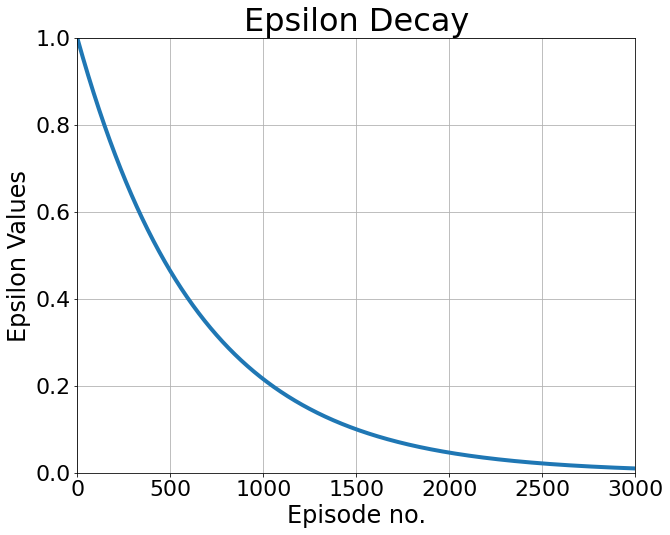

In [ ]:
# Epsilon-decay
plt.figure(figsize=(10, 8))
plt.plot(epsilon_values, linewidth=4)
plt.xlabel('Episode no.', fontsize=24)
plt.ylabel('Epsilon Values', fontsize=24)
plt.title('Epsilon Decay', fontsize=32)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=no_episodes)
plt.grid()
plt.show()

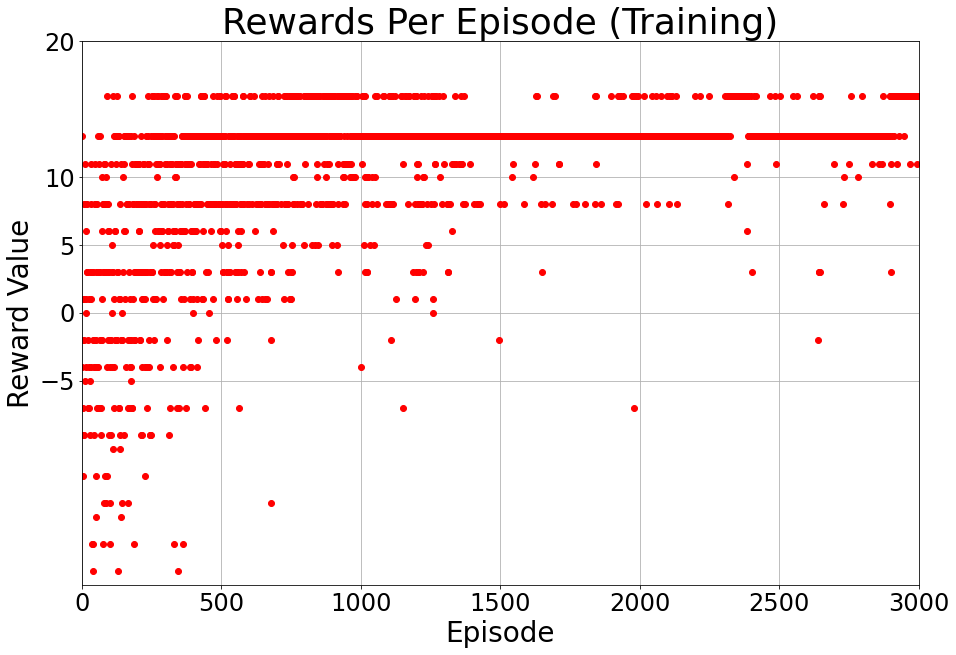

In [ ]:
# Reward Dynamics
plt.figure(figsize=(15, 10))
plt.plot(reward_per_episode, 'ro')
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks([--10, -5, 0, 5, 20], fontsize=24)
plt.ylim(ymin=-20, ymax=20)
plt.xlim(xmin=0, xmax=no_episodes)
plt.grid()
plt.show()

In [ ]:
# Images from
#All of these are free for non-commercial use
# https://lovepik.com/images/png-animal.html
# https://www.cleanpng.com/png-mousetrap-trapping-clip-art-mouse-trap-646405/download-png.html
# http://clipart-library.com/img/1734718.gif


# https://docs.python.org/3/library/pickle.html
# https://docs.python.org/3/library/copy.html

In [ ]:
rand = np.random.random()
rand

0.6130581516880009

In [ ]:
Qt

array([[ 7.8922116 ,  5.74556727,  6.42253586,  6.10087503],
       [ 8.76085409,  6.1692149 ,  6.32275382,  6.01010472],
       [ 9.8315342 ,  3.41543659,  6.77957013,  7.61005065],
       [ 6.70382144, 11.05047388,  7.10337016,  7.59227003],
       [ 5.08221743,  6.38955726,  5.30289327,  5.11901178],
       [ 4.09423398,  5.96968966,  5.12120633,  7.07725094],
       [10.62055695,  7.11804676,  6.63587182,  6.68048931],
       [ 7.16975955,  8.99641285,  4.87888038,  6.89108899],
       [ 7.09191409,  4.06598467,  5.72294521,  5.17653704],
       [ 7.88201316,  2.28584181,  6.01269433,  7.28721618],
       [ 8.70250882,  8.21108755,  6.6267859 ,  4.00729419],
       [ 8.87736648,  9.99705575,  7.90514285,  7.52435844],
       [-1.31707277,  2.89494787,  2.39091796,  5.4727837 ],
       [ 8.81683238,  2.28008375,  3.06885998,  3.10615721],
       [ 9.56323737,  8.48215779,  1.96687112,  7.54605333],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [ ]:
reward_per_episode

In [ ]:
Qt_reward_per_episode = [-7, -7, -14, -9, -4, -19, -9, -5, -9, -7, 3, 16, 13, 3, -32, -12, -2, -35, -19, 13, -19, -7, 0, 11, -2, -15, -14, -17, 11, 13, -12, -14, -12, -2, 3, -4, -9, -7, -7, -4, 3, -7, 8, 5, -2, 6, 3, 3, 3, -17, 11, -4, 3, 8, 16, -24, 6, -9, -2, 13, 3, -4, 16, 1, -7, 13, 13, 1, -4, -9, -27, -7, 1, -7, 6, 1, -2, 3, 16, -12, 11, 11, 8, -9, -2, -14, -2, 13, 6, 8, 8, 11, -4, -24, 8, -14, 16, 1, 11, 10, 8, -4, -9, 13, -2, 5, -2, -7, 3, 0, 6, -2, -2, 0, 8, -9, 11, -14, -2, 13, -14, -17, -17, 3, 11, -4, 8, 1, 8, 8, 1, 11, 11, 1, 8, -4, -14, 16, -12, 11, -4, 8, 11, 0, 13, -2, -9, 0, 11, 11, 13, 1, 13, 13, 13, 13, 3, 10, -19, 3, 16, 11, 6, 11, 8, 8, 11, 8, 11, 11, 13, 13, 13, 13, 8, 11, 8, 11, 8, 16, 13, 11, 1, 8, 8, 13, 11, 3, 8, 5, 1, 11, -4, 1, -4, 11, -14, -14, 11, 8, 13, 11, 13, 11, 8, 10, -5, 13, 3, 6, 13, 3, 8, 6, -2, -2, 8, 13, 13, 13, 11, 13, 16, -2, 13, 5, 1, -7, 8, -7, 6, -19, 13, 3, 13, 3, 5, 3, 16, 13, 16, 13, -4, 13, 10, 16, 13, 3, 13, 13, 11, 6, 11, 16, 3, 10, 3, 0, 8, 16, 13, 6, 3, 3, -4, 3, 6, 6, 6, 13, -4, 3, 13, 5, -2, 8, 3, 3, 16, 8, -2, 13, -17, 8, -2, 13, 13, 13, 1, 8, 8, 6, 3, -4, 11, 16, 8, 13, 8, 13, 11, 16, 1, 13, 8, 8, 16, -14, 6, 11, 11, 13, 1, 1, 13, 16, 13, 13, 16, 11, 11, 1, 13, 13, -2, 16, 13, 8, 16, 3, 13, 11, 13, 13, 13, 13, 13, 13, 8, 13, 8, 1, 3, 13, -4, 3, 11, 11, 13, 16, 16, 13, 3, 13, 8, 13, 13, 13, 13, 11, -9, 8, 8, 13, 11, 11, -4, 8, 11, 8, 16, 8, 11, 11, 16, 3, 13, 6, 3, 13, 13, 13, 13, 13, 8, 3, 6, 13, 13, 11, 13, 8, 13, 13, 6, 11, 8, 13, 13, 16, 13, 11, 13, 13, 5, 8, 13, 13, 13, 11, 11, 13, 13, 13, 13, 8, 8, 13, 13, 6, -7, 13, 8, 11, 10, 13, 16, 16, 13, 13, 11, 16, 8, 8, 16, 11, 11, 16, 11, 11, 13, 13, 13, 8, 13, 13, 6, 13, 8, 8, 8, 6, 13, 13, 13, 8, 8, 13, 16, 6, 16, 13, 13, 3, 1, 13, 16, 16, 13, 13, 13, 13, 13, 13, 8, 16, 16, 16, 1, 16, 16, 16, 6, 13, 13, -4, 6, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 8, 8, 13, 13, 13, 16, 1, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 5, 8, 13, 11, 11, 16, 16, 16, 13, 13, 3, 16, 11, 13, 13, 16, 8, 13, 16, 16, 11, 16, 8, 6, 11, 11, 11, 16, 13, 8, 13, 13, 13, 13, 13, 6, 16, 11, 13, 11, 3, 3, 16, 16, 13, -2, 13, 11, 8, 16, 11, 13, 13, 13, 13, 13, 11, 16, 13, 13, 16, 13, 11, 16, 13, 13, 10, 10, 13, 13, 13, 13, 1, 13, 13, -2, 13, 13, 11, 16, 13, 16, 13, 16, 8, 16, 13, 8, 13, 13, 13, 11, 11, 13, 13, 13, 6, 13, 13, 16, 11, 16, 13, 13, 8, 11, 11, 13, 11, 10, 13, 11, 11, 8, 16, 13, 16, 8, -2, 13, 13, 8, 10, 5, 13, 13, 13, 16, 10, 8, 13, 16, 16, 8, 3, 11, 13, 11, 13, 13, 13, 13, 13, 11, 16, 11, 11, 11, 8, 8, 13, 6, 3, 8, 13, 16, 11, 16, 13, 13, 16, 8, 8, 11, 13, 13, 13, 13, 8, 13, 13, 13, 11, 13, 13, 13, 8, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 8, 16, -2, 13, 13, 6, 13, 13, 13, 16, 13, 16, 16, 13, 13, 13, 13, 13, 0, 13, 3, 13, 13, 13, 16, 11, 16, 13, 16, 16, 13, 13, 11, 16, 16, 13, 13, 16, 13, 13, 13, 13, 8, 13, 8, 13, 13, 13, 16, 13, 8, 13, 13, 13, 13, 13, 8, 11, 16, 16, 16, 13, 13, 13, 8, 8, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 16, 13, 13, 13, 11, 16, 13, 13, 13, 11, 13, 13, 16, 13, 13, 13, 13, 16, 13, 16, 16, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 13, 16, 13, 13, 16, 16, 11, 6, 11, 13, 13, 11, 16, 16, 13, 16, 13, 16, 13, 13, 16, 13, 13, 11, 13, 13, 13, 11, 13, 11, 13, 16, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 16, 13, 13, 13, 13, 13, 8, 11, 13, 13, 13, 16, 13, 13, -2, 13, 13, 13, 13, 13, 11, 16, 16, 10, 13, 13, 16, 13, 13, 16, 13, 13, 11, 13, 13, 13, 13, 13, 11, 13, 13, 13, 11, 13, 8, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 11, 13, 8, 11, 13, 13, 16, 13, 16, 16, 13, 13, 16, 16, 16, 16, 16, 11, 13, 16, 11, 13, 16, 13, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 13, 16, 16, 16, 16, 16, 16, 16, 16, 11, 16, 11, 16, 13, 16, 16, 16, 16, 10, 11, 16, 11, 16, 16, 16, 11, 16, 16, 11, 13, 16, 16, 11, 16, 11, 16, 16, 16, 11, 11, 16, 11, 16, 3, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 8, 13, 16, 13, 13, 13, 13, -2, 3, 3, 13, 16, 16, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 16, 13, 13, 8, 11, 13, 13, 11, 13, 11, 13, 13, 16, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 6, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 8, 13, 13, 8, 13, 13, 13, 13, 13, 1, 16, 6, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 16, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 8, 13, 16, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, -7, -2, 13, 16, 16, 16, 13, 13, 11, 13, 13, 13, 13, 13, 11, 3, 16, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, -2, 3, 13, 13, 16, 16, 13, 13, 16, 13, 10, 13, 13, 13, 13, 3, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 8, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, -2, 3, 6, 1, 6, 6, 13, 3, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 6, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 16, 13, 13, 13, 13, 13, 13, 13, 11, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 16, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 8, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]

<ipython-input-183-490e69649822>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(Ql_reward_per_episode,'ro', color='green', label='Q-Learning' )


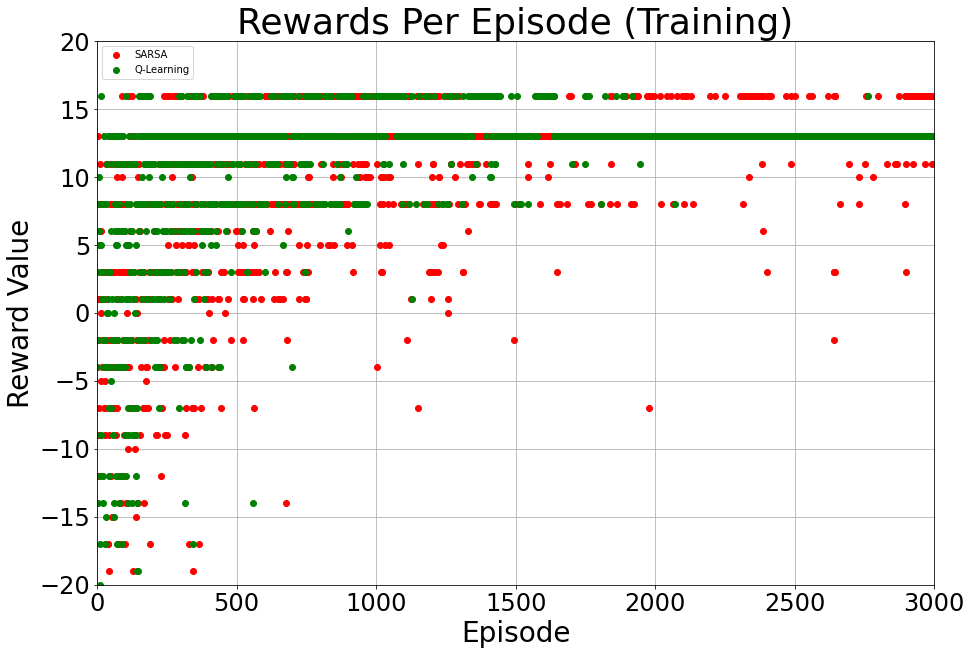

In [ ]:
# Reward Dynamics
plt.figure(figsize=(15, 10))
plt.plot(reward_per_episode, 'ro', label ='SARSA')
plt.plot(Ql_reward_per_episode,'ro', color='green', label='Q-Learning' )
plt.xlabel('Episode', fontsize=28)
plt.ylabel('Reward Value', fontsize=28)
plt.title('Rewards Per Episode (Training)', fontsize=36)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylim(ymin=-20, ymax=20)
plt.xlim(xmin=0, xmax=no_episodes)
plt.legend(loc="upper left")

plt.grid()
plt.show()